## Feature Importance Analysis (SHAP)


### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-12-13 15:34:14.743942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 15:34:17.003641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 15:34:19.676292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from sim import *
from sim import sim_run
from sim import plot

# overall imports
import importlib
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

import data.data_utils
from data.data_utils import process_cv_splits

# cross-validation classes
from data.cv_split import (
    RandomCVSplit, 
    SchaeferCVSplit, 
    CommunityCVSplit, 
    SubnetworkCVSplit
)
import data.cv_split

from data.data_load import load_transcriptome, load_connectome, load_coords


In [4]:
# Specify path to saved simulations
feature_types = ['transcriptome', 'transcriptomePCA', 'structural', 'euclidean', 'functional']
sim_path = os.getcwd() + '/sim/sim_results/'
os.listdir(sim_path)

['structural_spectralA_-20_SC_xgboost_random_42_bayes_mse_search.pickle',
 'structural_spectralA_10_FC_xgboost_community101_4_bayes_mse_search.pickle',
 'structural_spectralL_-60_FC_xgboost_random_42_bayes_mse_search.pickle',
 'structural_spectralA_10_FC_mlp_community101_42_grid_mse_search.pickle',
 'transcriptome_FC_xgboost_random_2_bayes_mse_search.pickle',
 'transcriptome structural_spectralA_10_FC_pls_community101_5_grid_mse_search.pickle',
 'structural_spectralL_-60_SC_xgboost_random_42_bayes_mse_search.pickle',
 'transcriptome structural_spectralA_10_FC_pls_community101_1_grid_mse_search.pickle',
 'transcriptome_FC_mlp_community101_5_grid_mse_search.pickle',
 'structural_spectralL_10_FC_ridge_random_42_grid_mse_search.pickle',
 'transcriptome_structural_spectral_A_20_FC_ridge_random_42_grid_mse_search.pickle',
 'structural_spectralL_3_FC_xgboost_random_42_bayes_mse_search.pickle',
 'transcriptome_FC_pls_community101_1_grid_mse_search.pickle',
 'transcriptome_SC_xgboost_community1

### Sim Run with XGBoost Model Saved as JSON within Sim Results Pickle

In [5]:
results = open_pickled_results('transcriptome_FC_xgboost_random_2_bayes_mse_search.pickle')

In [6]:
# Example loop to show how to extract the model from each train-test fold
# In this case there are 4 folds, thus 4 models 
for fold in results[0]: 
    print(fold.keys())
    print(fold['train_metrics'])
    print(fold['test_metrics']) # this will be replaced with model_json
    print(fold['feature_importances'].shape)


dict_keys(['model_parameters', 'train_metrics', 'best_val_score', 'test_metrics', 'y_true', 'y_pred', 'feature_importances', 'model_json'])
{'mse': 0.014831279731915075, 'mae': 0.0819091276066069, 'r2': 0.30564890908261627, 'pearson_corr': 0.7869500066076349, 'connectome_corr': 0.6522652776969675, 'connectome_r2': 0.2771600170159091, 'geodesic_distance': 9.746608503490942}
{'mse': 0.02148450804813151, 'mae': 0.11211099762817703, 'r2': -0.23965096286954973, 'pearson_corr': 0.4632457959399317, 'connectome_corr': 0.304487509853925, 'connectome_r2': -0.5537247314253684, 'geodesic_distance': 5.473043482546301}
(22106,)
dict_keys(['model_parameters', 'train_metrics', 'best_val_score', 'test_metrics', 'y_true', 'y_pred', 'feature_importances', 'model_json'])
{'mse': 3.42345573209367e-05, 'mae': 0.004373363049060336, 'r2': 0.9958498700530615, 'pearson_corr': 0.9995398704167768, 'connectome_corr': 0.9980582036104715, 'connectome_r2': 0.9955852801581779, 'geodesic_distance': 2.757046740790688}
{

Training and testing data to compute shap values with

In [7]:
# Corresponding data for each fold - make sure identical to above simulation
X = load_transcriptome(omit_subcortical=False, parcellation='S100', run_PCA=False)
Y = load_connectome(omit_subcortical=False, parcellation='S100', measure='FC')
random_obj = RandomCVSplit(X, Y, num_splits=4, shuffled=True, use_random_state=True, random_seed=2)

fold_splits = process_cv_splits(X, Y, random_obj)

INPUT: Fold 0 shapes - X_train: (85, 11053), X_test: (29, 11053), Y_train: (85, 85), Y_test: (29, 29)
Number of combinations: 3570
Number of combinations: 406
PROCESSED: Fold 0 shapes - X_train: (7140, 22106), X_test: (812, 22106), Y_train: (7140,), Y_test: (812,)
INPUT: Fold 1 shapes - X_train: (85, 11053), X_test: (29, 11053), Y_train: (85, 85), Y_test: (29, 29)
Number of combinations: 3570
Number of combinations: 406
PROCESSED: Fold 1 shapes - X_train: (7140, 22106), X_test: (812, 22106), Y_train: (7140,), Y_test: (812,)
INPUT: Fold 2 shapes - X_train: (86, 11053), X_test: (28, 11053), Y_train: (86, 86), Y_test: (28, 28)
Number of combinations: 3655
Number of combinations: 378
PROCESSED: Fold 2 shapes - X_train: (7310, 22106), X_test: (756, 22106), Y_train: (7310,), Y_test: (756,)
INPUT: Fold 3 shapes - X_train: (86, 11053), X_test: (28, 11053), Y_train: (86, 86), Y_test: (28, 28)
Number of combinations: 3655
Number of combinations: 378
PROCESSED: Fold 3 shapes - X_train: (7310, 221

In [8]:
for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(fold_splits):
    print(fold_idx+1)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

1
(7140, 22106)
(7140,)
(812, 22106)
(812,)
2
(7140, 22106)
(7140,)
(812, 22106)
(812,)
3
(7310, 22106)
(7310,)
(756, 22106)
(756,)
4
(7310, 22106)
(7310,)
(756, 22106)
(756,)


- Will need to use the above train, test splits to evaluate feature importance. https://github.com/shap/shap
- Can use train set, test set, or both to explain feature importance. Let's run all 3 variations for now
- Can also evaluate genes that are most stable over all folds as an indicator of which genes are stable across the brain.

  if np.issubdtype(dtype_in, np.dtype(dtype).type):



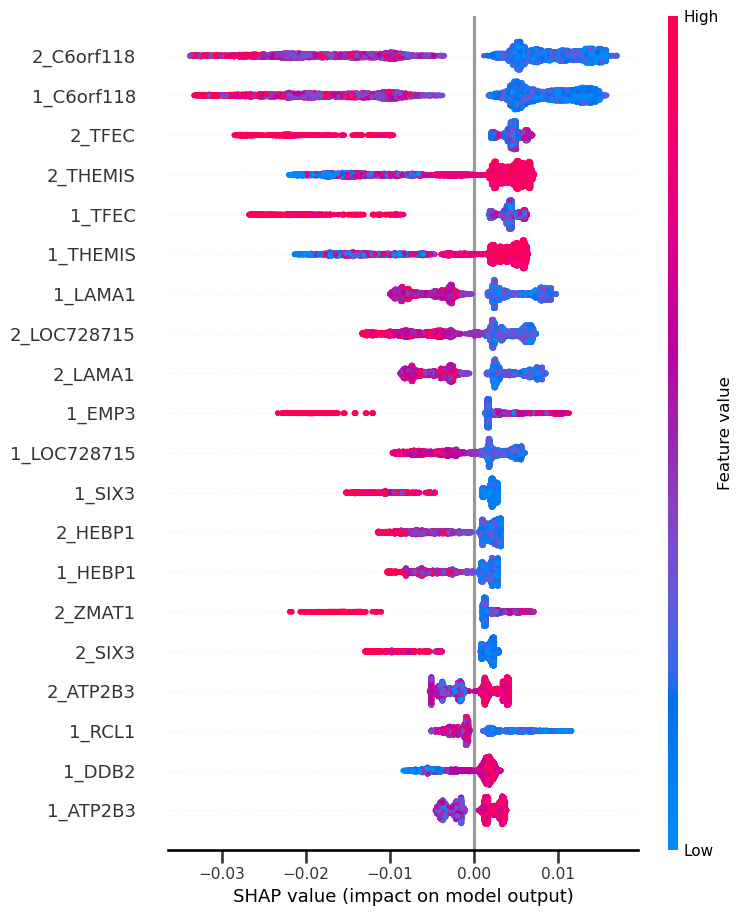

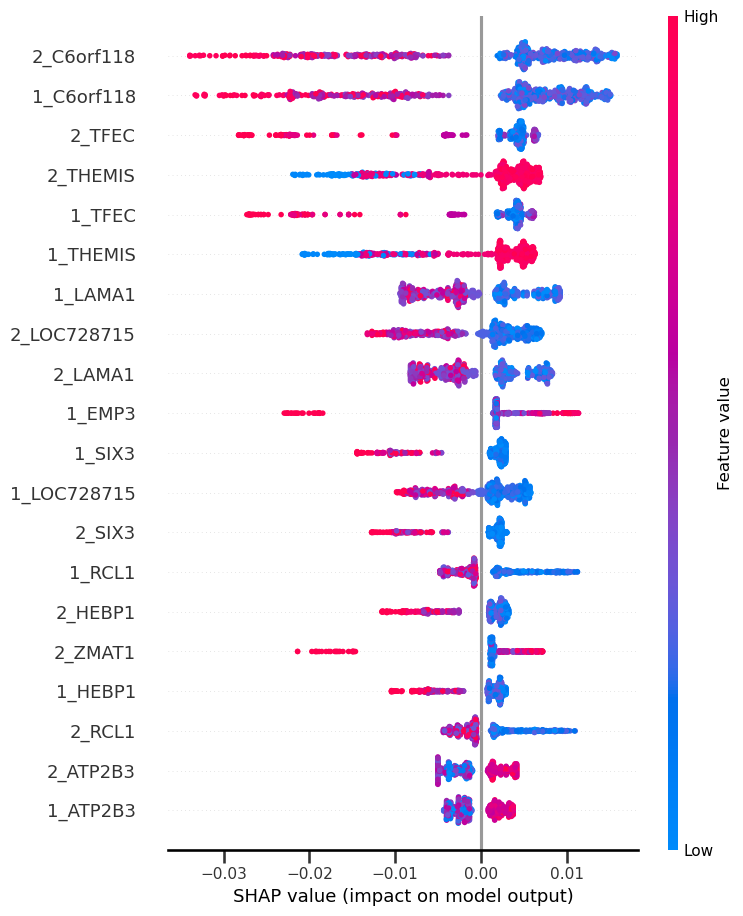

In [9]:
import xgboost as xgb
import shap 

model = xgb.Booster()
model_json = results[0][0]['model_json'] # fold 3 trained model - best performing train-test split
model.load_model(bytearray(model_json, 'utf-8'))
model

schaefer114_genes = pd.read_csv("./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
gene_list = list(pd.unique(["1_" + x for x in schaefer114_genes.columns[1:].tolist()] +
                           ["2_" + x for x in schaefer114_genes.columns[1:].tolist()]))

explainer = shap.TreeExplainer(model)

def plot_and_get_shap_values(exp, dataset, columns, bar=False):
    dataset = pd.DataFrame(dataset, columns=columns)
    shap_values = exp.shap_values(dataset)
    if bar:
        shap.summary_plot(shap_values, dataset, plot_type="bar")
    else:
        shap.summary_plot(shap_values, dataset)
    shap_df = pd.DataFrame(shap_values, columns=columns)
    return shap_df

train_shap_df_fold0 = plot_and_get_shap_values(explainer, X_train, gene_list)
test_shap_df_fold0 = plot_and_get_shap_values(explainer, X_test, gene_list)

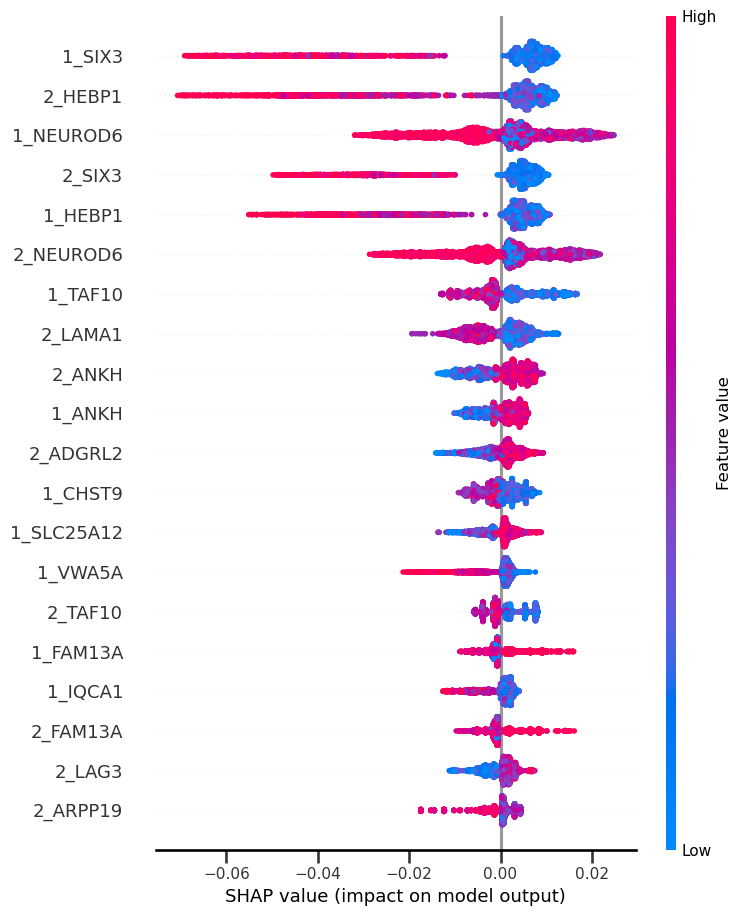

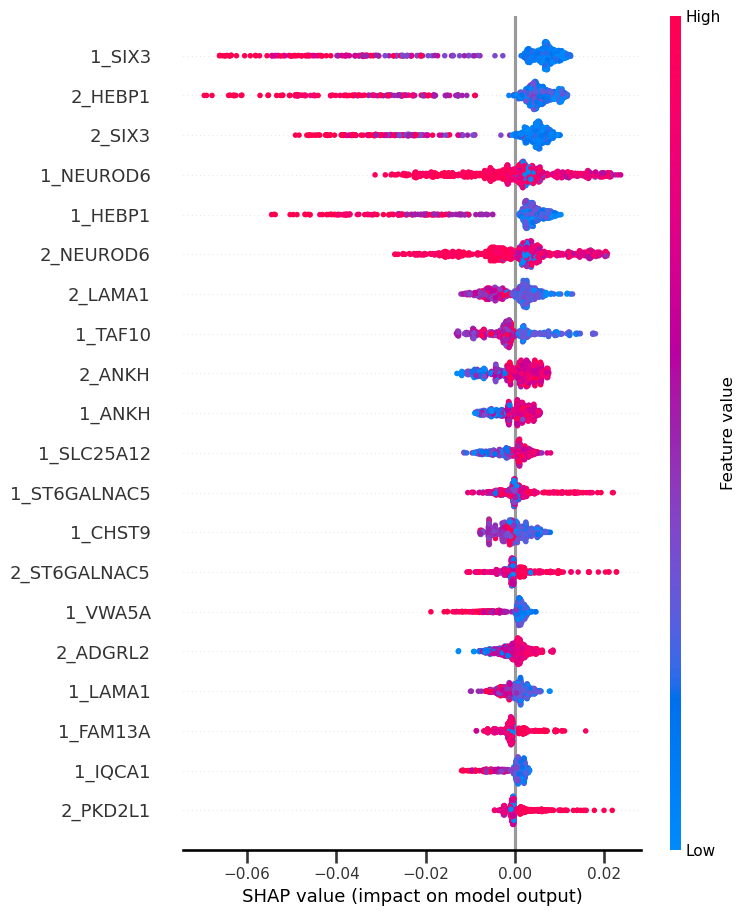

In [10]:
model = xgb.Booster()
model_json = results[0][1]['model_json'] # fold 3 trained model - best performing train-test split
model.load_model(bytearray(model_json, 'utf-8'))
model

explainer = shap.TreeExplainer(model)

train_shap_df_fold1 = plot_and_get_shap_values(explainer, X_train, gene_list)
test_shap_df_fold1 = plot_and_get_shap_values(explainer, X_test, gene_list)

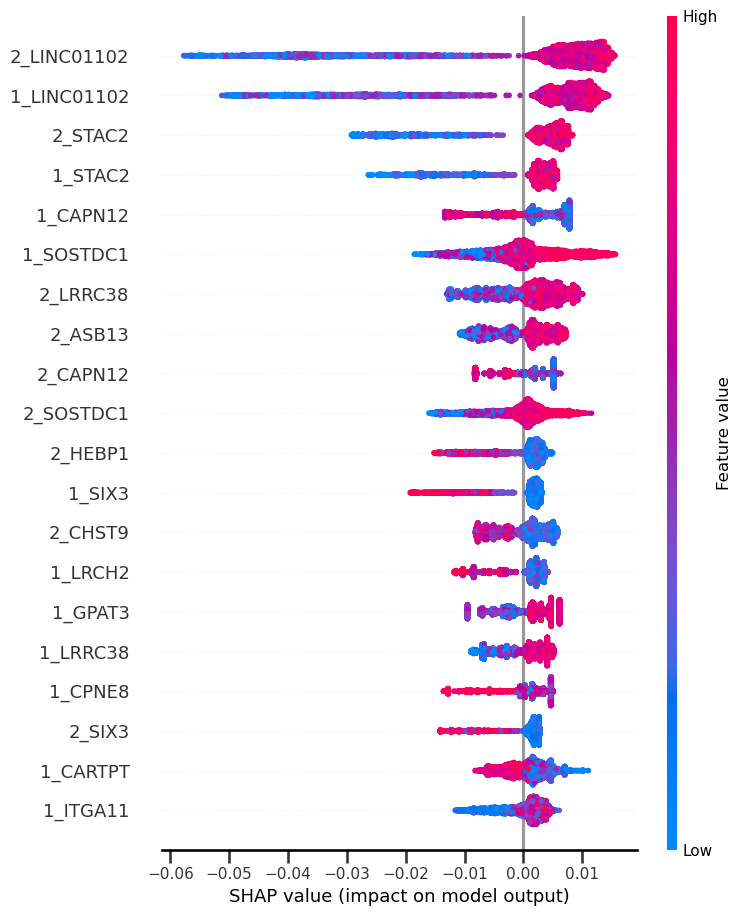

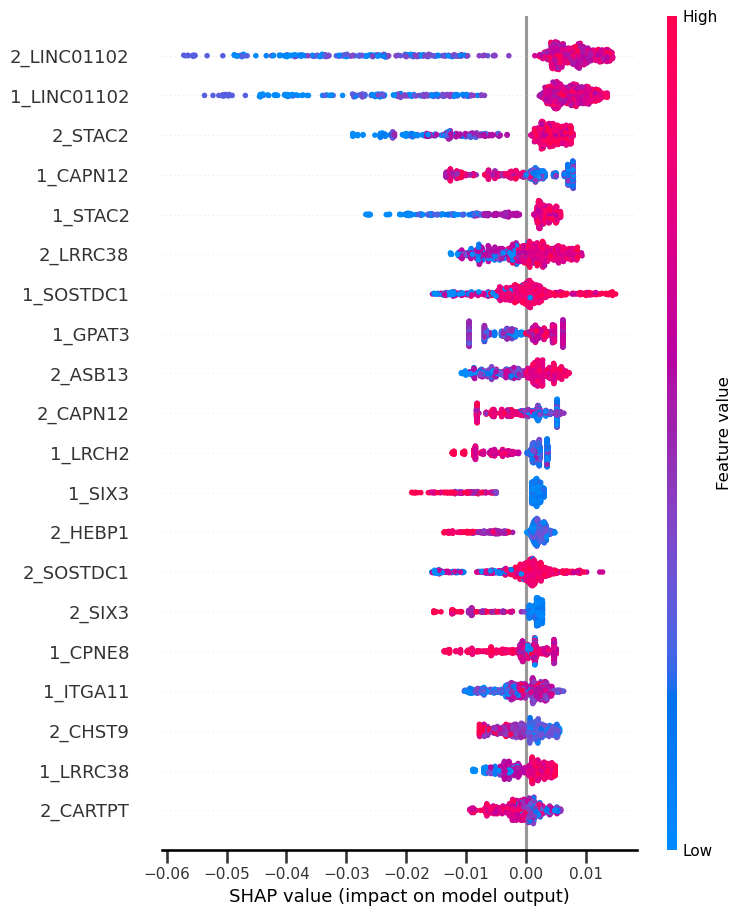

In [11]:
model = xgb.Booster()
model_json = results[0][2]['model_json'] # fold 3 trained model - best performing train-test split
model.load_model(bytearray(model_json, 'utf-8'))
model

explainer = shap.TreeExplainer(model)

train_shap_df_fold2 = plot_and_get_shap_values(explainer, X_train, gene_list)
test_shap_df_fold2 = plot_and_get_shap_values(explainer, X_test, gene_list)

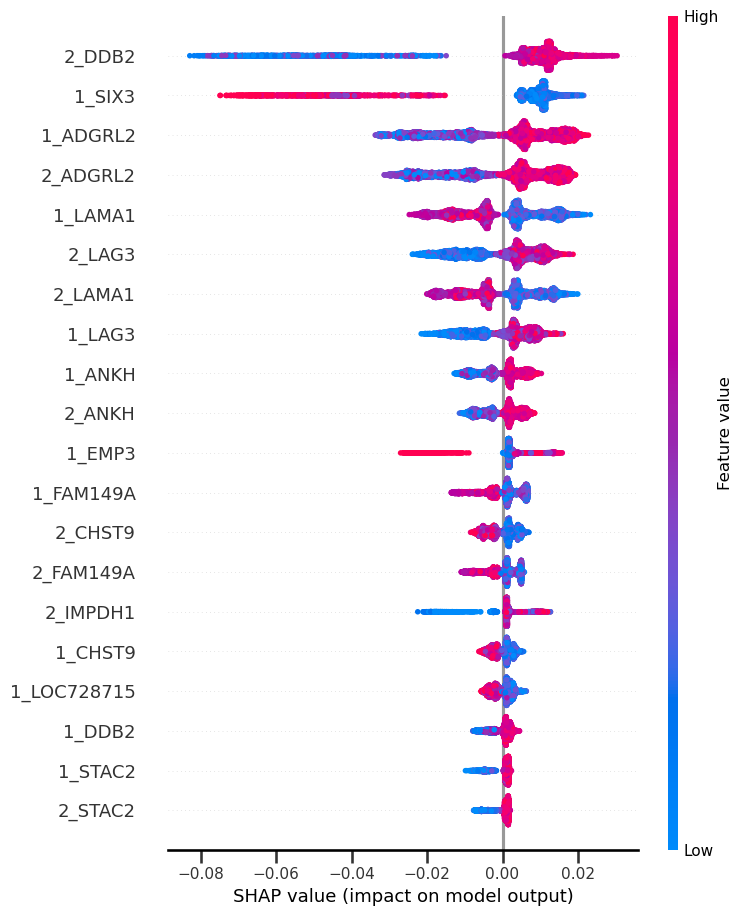

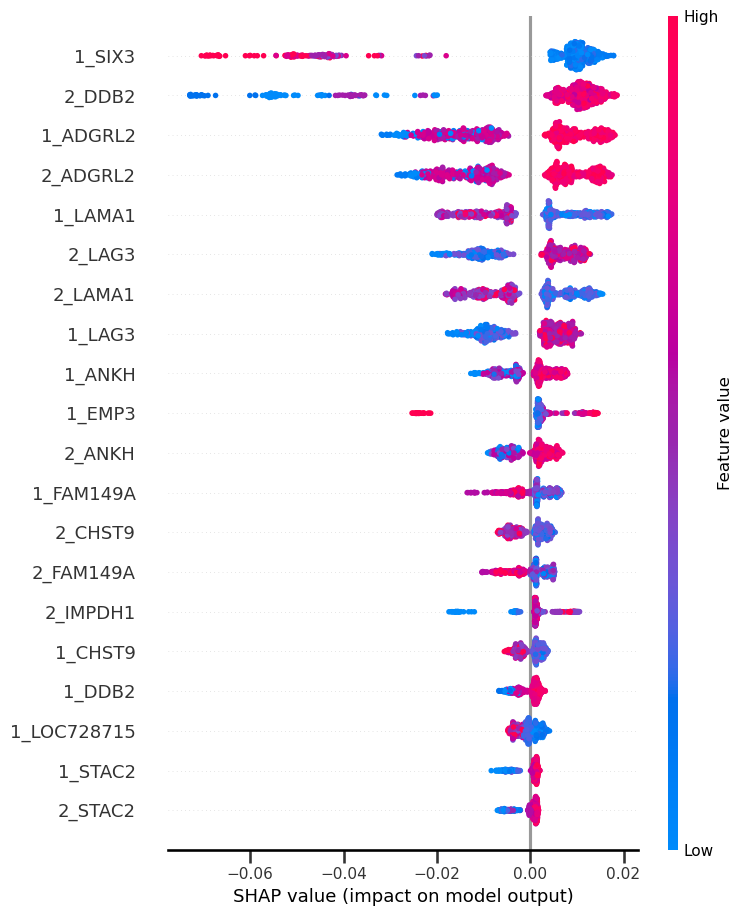

In [12]:
model = xgb.Booster()
model_json = results[0][3]['model_json'] # fold 3 trained model - best performing train-test split
model.load_model(bytearray(model_json, 'utf-8'))
model

explainer = shap.TreeExplainer(model)

train_shap_df_fold3 = plot_and_get_shap_values(explainer, X_train, gene_list)
test_shap_df_fold3 = plot_and_get_shap_values(explainer, X_test, gene_list)


In [13]:
test_shap_df_fold0.mean()

1_A1BG       -0.000111
1_A1BG-AS1    0.000000
1_AAAS        0.000000
1_AACS        0.000000
1_AADAT       0.000000
                ...   
2_ZXDC        0.000000
2_ZYG11B      0.000000
2_ZYX         0.000000
2_ZZEF1       0.000000
2_ZZZ3        0.000000
Length: 22106, dtype: float32

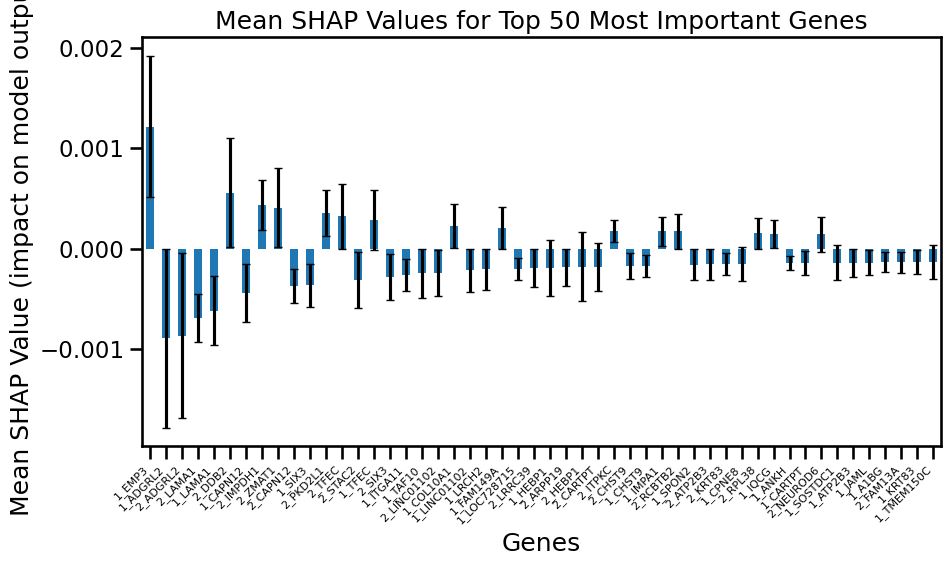

In [32]:
# Calculate mean and std error across folds
# First compute mean shapley values within each test set
test_shap_dfs = [test_shap_df_fold0, test_shap_df_fold1, test_shap_df_fold2, test_shap_df_fold3]
test_set_means = [df.mean() for df in test_shap_dfs]  # Mean for each gene within each test set

# Then compute mean and standard error across test sets
test_set_means_df = pd.concat(test_set_means, axis=1)  # Combine means from each test set
gene_means = test_set_means_df.mean(axis=1)  # Mean across test sets for each gene
gene_stderrs = test_set_means_df.std(axis=1) / np.sqrt(len(test_shap_dfs))  # Standard error across test sets

# Function to plot top N genes with error bars
def plot_top_genes(gene_means, gene_stderrs, n_top=50):
    # Sort values and get top N genes
    top_indices = gene_means.abs().sort_values(ascending=False).head(n_top).index
    top_n_genes = gene_means[top_indices]
    top_n_stderrs = gene_stderrs[top_indices]
    
    # Create bar plot for top N genes with error bars
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    top_n_genes.plot(kind='bar', yerr=top_n_stderrs, capsize=3, ax=ax)
    plt.title(f'Mean SHAP Values for Top {n_top} Most Important Genes')
    plt.xlabel('Genes')
    plt.ylabel('Mean SHAP Value (impact on model output)')
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Decreased font size to 8
    plt.tight_layout()
    plt.show()

# Plot top 10 genes by default
plot_top_genes(gene_means, gene_stderrs)


In [36]:
# Create summary dataframe with genes, mean SHAP values and standard errors
test_shap_summary = pd.DataFrame({
    'gene': gene_means.index,
    'mean_shap': gene_means.values,
    'std_error': gene_stderrs.values
})

# Sort by absolute mean SHAP value
test_shap_summary = test_shap_summary.reindex(
    test_shap_summary.mean_shap.abs().sort_values(ascending=False).index
)


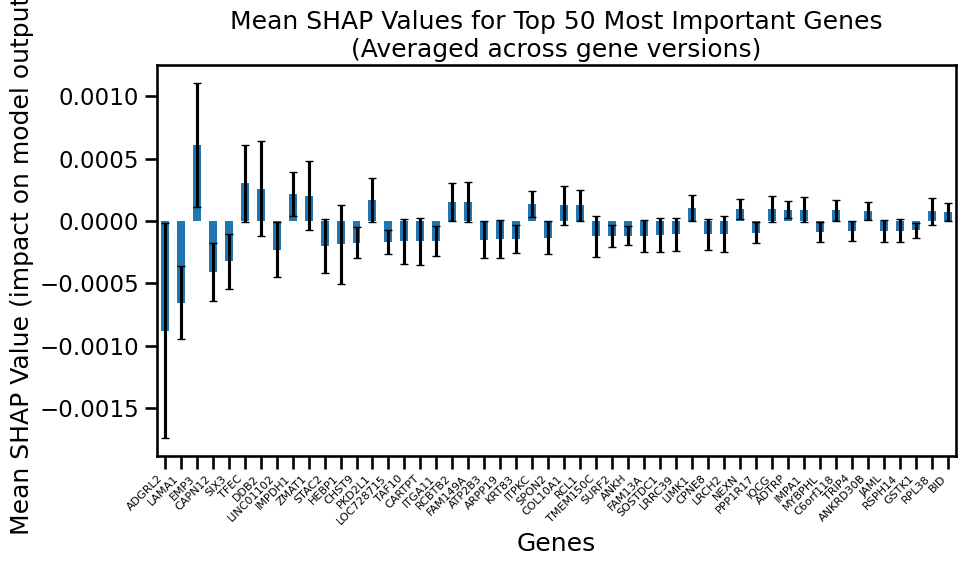

In [42]:
# Calculate mean and std error across folds
# First compute mean shapley values within each test set
test_shap_dfs = [test_shap_df_fold0, test_shap_df_fold1, test_shap_df_fold2, test_shap_df_fold3]
test_set_means = [df.mean() for df in test_shap_dfs]  # Mean for each gene within each test set

# Then compute mean and standard error across test sets
test_set_means_df = pd.concat(test_set_means, axis=1)  # Combine means from each test set
gene_means = test_set_means_df.mean(axis=1)  # Mean across test sets for each gene
gene_stderrs = test_set_means_df.std(axis=1) / np.sqrt(len(test_shap_dfs))  # Standard error across test sets

# Aggregate 1_ and 2_ versions of genes
def aggregate_gene_versions(means, stderrs):
    # Remove prefix and aggregate
    gene_dict = {}
    stderr_dict = {}
    
    for gene, value in means.items():
        base_gene = gene[2:]  # Remove '1_' or '2_' prefix
        if base_gene not in gene_dict:
            gene_dict[base_gene] = []
            stderr_dict[base_gene] = []
        gene_dict[base_gene].append(value)
        stderr_dict[base_gene].append(stderrs[gene])
    
    # Calculate mean across versions
    aggregated_means = {g: np.mean(v) for g, v in gene_dict.items()}
    # Propagate errors
    aggregated_stderrs = {g: np.sqrt(np.mean(np.array(v)**2)) for g, v in stderr_dict.items()}
    
    return pd.Series(aggregated_means), pd.Series(aggregated_stderrs)

# Aggregate gene versions
agg_gene_means, agg_gene_stderrs = aggregate_gene_versions(gene_means, gene_stderrs)

# Function to plot top N genes with error bars
def plot_top_genes(gene_means, gene_stderrs, n_top=50):
    # Sort values and get top N genes
    top_indices = gene_means.abs().sort_values(ascending=False).head(n_top).index
    top_n_genes = gene_means[top_indices]
    top_n_stderrs = gene_stderrs[top_indices]
    
    # Create bar plot for top N genes with error bars
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    top_n_genes.plot(kind='bar', yerr=top_n_stderrs, capsize=3, ax=ax)
    plt.title(f'Mean SHAP Values for Top {n_top} Most Important Genes\n(Averaged across gene versions)')
    plt.xlabel('Genes')
    plt.ylabel('Mean SHAP Value (impact on model output)')
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Decreased font size to 8
    plt.tight_layout()
    plt.show()

# Plot top 10 genes by default using aggregated values
plot_top_genes(agg_gene_means, agg_gene_stderrs)


In [44]:
# Create summary dataframe with genes, mean SHAP values and standard errors
single_gene_test_shap_summary = pd.DataFrame({
    'gene': agg_gene_means.index,
    'mean_shap': agg_gene_means.values,
    'std_error': agg_gene_stderrs.values
})

# Sort by absolute mean SHAP value
single_gene_test_shap_summary = single_gene_test_shap_summary.reindex(
    single_gene_test_shap_summary.mean_shap.abs().sort_values(ascending=False).index
)


In [46]:
single_gene_test_shap_summary.to_csv('gene_test_shap_xgboost.csv', index=False)